[]

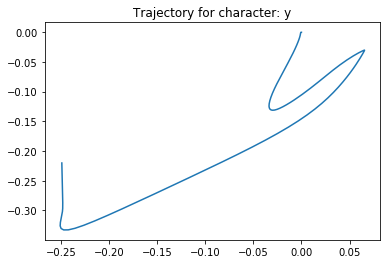

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
%matplotlib inline

data_dir = '../data'
data = loadmat('../data/mixoutALL_shifted.mat')
        
# Char labels N x 1 vec of labels 1-20
char_labels = data['consts']['charlabels'][0][0].T

# Key maps label to character via key[label-1]
key = data['consts']['key'][0][0].T.squeeze()

# Trajectories in list of N trajectories - each may be a different length so cannot put into one matrix
trajectories = data['mixout'].T

N, _ = char_labels.shape

# Let's choose a random trajectory and look at it
np.random.seed(0)
n = np.random.randint(0, N)
trajectory = trajectories[n, 0].T
label = char_labels[n]

# Suppose we start at [0, 0] and sampling as done in 200Hz (from dataset) -- roughly integrate
positions = np.cumsum(trajectory[:, :2], axis=0) / 200.0
accelerations = np.diff(trajectory[:, :2], axis=0) * 200.0

plt.plot(positions[:, 0], positions[:, 1])
plt.title('Trajectory for character: {}'.format(key[label-1][0][0]))
plt.plot()


In [2]:
# Try doing inverse jacobian
import copy

def J(q, l1=0.5, l2=0.5):
    return np.asarray([[-l1 * np.sin(q[0]) - l2 * np.sin(q[0] + q[1]), -l2 * np.sin(q[0] + q[1])],
                     [l1 * np.cos(q[0]) + l2 * np.cos(q[0] + q[1]), l2 * np.cos(q[0] + q[1])]])

q_init = np.asarray([np.pi/4.0, np.pi/2.0])
q = q_init.copy()
q_dot = []
for i in range(len(trajectory)):
    # q_dot
    v = trajectory[i, :2]
    q_d = np.linalg.solve(J(q), v)
    q += q_d / 200.0
    q_dot.append(q_d)
    
q_dot = np.asarray(q_dot)
q = q_init + np.cumsum(q_dot, axis=0) / 200.0
q_ddot = np.concatenate((np.zeros((1, 2)), np.diff(q_dot, axis=0))) * 200



In [3]:
# How do these q's look?
import gym
import gym_cenvs
import time

env = gym.make('Reacher-v0')
#env = gym.make('DoublePendulum-v0')
observation = env.reset()
#env.unwrapped.set_state(state)

time.sleep(10)
for t in range(len(q)):
    state = np.concatenate((q[t], np.zeros(2)), axis=0)
    env.unwrapped.set_state(state)
    observation, reward, done, _ = env.step(np.zeros(2))
    env.unwrapped.set_state(state)

    time.sleep(0.1)
    env.render()
    
env.close()